# 4. 데이터 변환 – 특징 생성

## 목적 및 필요성
1. 품질 확보 : 가공을 거치지 않은 Raw 데이터 활용 기반의 모델은 품질 확보가 어려움
2. 최적화된 형태 변환 : 분석 알고리즘마다 요구하는 적절한 형태가 존재한다. 때문에 분석 목적과 환경에 적용 가능한 적절한 특징(feature)을 확보하는 것이 모델 성능과 밀접한 연관이 있다.
    - 데이터 경진대회 수상자들의 인터뷰를 보면, 많은 수상자들이 feature engineering, 적절한 특징을 생성하는 것을 중요하다고 말한다. 머신러닝, 딥러닝 알고리즘은 많지만, 그 전에 데이터에서 적절한 특징을 확보하는 것이 데이터 분석 내 가장 중요한 과정이라고 한다.<br><br>


## 특징 생성
1. 범주 인코딩 기반 생성
    - One-hot Encoding
2. 결합 및 분해 기반 생성
    - Add / Divide / Subtract : 평균, 편차 등을 파악
    - Multiply : '상호작용항(Interaction Feature)'으로, 여러 데이터 간 시너지 효과를 파악 (도메인 지식 기반 검토가 필요하다)
    - Separate ; 이력성을 가지는 데이터(연월일 등)를 다시 연, 월, 일 등으로 쪼개는 것
3. 차원 축소 기반 생성 (알고리즘 적용)
    - PCA(Principal Component Analysis) : 서로 연관된 변수들이 관측되었을 때 이를 주성분으로 결합하고, 주성분 간은 서로 독립을 이루도록 구성함으로써 저차원 데이터로 차원 축소
    - Featurization via Clustering : 고차원 데이터에 대해 군집 분석을 기반으로, 특징의 개수를 하나의 특징으로 축소. 이렇게 얻은 군집 결과 특징을 분류/회귀를 위한 입력 변수로 활용(Stacking)
<br><br>

## 실습 내용 요약
- 에제 데이터를 활용한 범주형 변수 인코딩, 결합 및 분해 기반의 신규 특징 생성
- 주성분 분석, 군집 분석 기반 특징 생성 학습

## 4-1. 범주 인코딩 기반 특징 생성 - One-hot Encoding

In [3]:
import numpy as np
import pandas as pd

In [2]:
# 실습 데이터 로딩
data = pd.read_csv("./data/purchase_data.csv")
data.head(10)

,date,purchase_YN,gender,city
0,2021-08-27 13:09:30,1,F,Daegu
1,2021-05-25 21:08:56,0,M,Busan
2,2020-02-09 17:35:09,1,M,Daejun
3,2022-01-22 16:41:40,0,F,Gwangju
4,2021-06-11 07:46:15,1,M,Daegu
5,2021-06-01 09:51:33,1,F,Daejun
6,2020-03-25 23:34:01,0,F,Gwangju
7,2022-06-19 02:53:56,0,M,Seoul
8,2021-07-25 14:00:55,0,F,Daejun
9,2020-02-26 20:56:16,0,M,Seoul


In [3]:
# 도시의 범주는 5개임을 확인할 수 있다.
data['city'].value_counts()

Gwangju    64
Daegu      63
Daejun     63
Busan      57
Seoul      53
Name: city, dtype: int64

In [4]:
# city라는 범주형 데이터를 one hot encoding 할 것
# pandas의 get_dummies 함수를 활용해 쉽게 구현할 수 있다.
encoding_data = data.copy()
encoding_data = pd.get_dummies(encoding_data, columns=['city'])
encoding_data.head()

,date,purchase_YN,gender,city_Busan,city_Daegu,city_Daejun,city_Gwangju,city_Seoul
0,2021-08-27 13:09:30,1,F,0,1,0,0,0
1,2021-05-25 21:08:56,0,M,1,0,0,0,0
2,2020-02-09 17:35:09,1,M,0,0,1,0,0
3,2022-01-22 16:41:40,0,F,0,0,0,1,0
4,2021-06-11 07:46:15,1,M,0,1,0,0,0


- One-hot Encoding은 어떠한 범주 데이터들을 별도 column으로 생성해 true/false를 표현
- 기계학습의 많은 알고리즘은 수치형 데이터를 입력값으로 받아야 하기 때문에, One-hot Encoding 기법을 통해 기계학습의 제약점 해소 가능

## 4-2. 결합 및 분해 기반 특징 생성

In [5]:
# 시간대 별 파악 목적
# 어느 시간대 혹은 요일 별로 구매 결정이 높아지는지 확인하고자 할 때

creation_data = data.copy()
creation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         300 non-null    object
 1   purchase_YN  300 non-null    int64 
 2   gender       300 non-null    object
 3   city         300 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.7+ KB


In [6]:
# 기존 범주형 변수인 date 컬럼을 datetime 형식으로 변환
creation_data['date'] = pd.to_datetime(creation_data['date'])
creation_data.head()

,date,purchase_YN,gender,city
0,2021-08-27 13:09:30,1,F,Daegu
1,2021-05-25 21:08:56,0,M,Busan
2,2020-02-09 17:35:09,1,M,Daejun
3,2022-01-22 16:41:40,0,F,Gwangju
4,2021-06-11 07:46:15,1,M,Daegu


In [7]:
# 데이터 타입 확인
# object -> datetime 임을 확인할 수 있다.
creation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         300 non-null    datetime64[ns]
 1   purchase_YN  300 non-null    int64         
 2   gender       300 non-null    object        
 3   city         300 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 11.7+ KB


In [8]:
# date 컬럼을 연/월/일/요일 등의 의미를 지닌 변수로 분해
creation_data['year'] = creation_data['date'].dt.year
creation_data['month'] = creation_data['date'].dt.month
creation_data['day'] = creation_data['date'].dt.day
creation_data['hour'] = creation_data['date'].dt.hour
creation_data['dayofweek'] = creation_data['date'].dt.dayofweek # 요일 (월 = 0)
creation_data.head()

,date,purchase_YN,gender,city,year,month,day,hour,dayofweek
0,2021-08-27 13:09:30,1,F,Daegu,2021,8,27,13,4
1,2021-05-25 21:08:56,0,M,Busan,2021,5,25,21,1
2,2020-02-09 17:35:09,1,M,Daejun,2020,2,9,17,6
3,2022-01-22 16:41:40,0,F,Gwangju,2022,1,22,16,5
4,2021-06-11 07:46:15,1,M,Daegu,2021,6,11,7,4


In [9]:
# 오전, 오후의 의미를 지니는 변수 생성을 위한 결헙
# AM, PM 구분 변수 생성
# 아래 loc의 의미는 (행, 열), creation_date['hour'] > 12인 행을 골라
# 'ampm' 열에 'PM" 이라는 값을 삽입'
creation_data['ampm'] = 'AM'
creation_data.loc[creation_data['hour'] > 12, 'ampm'] = 'PM'
creation_data

,date,purchase_YN,gender,city,year,month,day,hour,dayofweek,ampm
0,2021-08-27 13:09:30,1,F,Daegu,2021,8,27,13,4,PM
1,2021-05-25 21:08:56,0,M,Busan,2021,5,25,21,1,PM
2,2020-02-09 17:35:09,1,M,Daejun,2020,2,9,17,6,PM
3,2022-01-22 16:41:40,0,F,Gwangju,2022,1,22,16,5,PM
4,2021-06-11 07:46:15,1,M,Daegu,2021,6,11,7,4,AM
...,...,...,...,...,...,...,...,...,...,...
295,2021-08-30 21:16:18,1,M,Busan,2021,8,30,21,0,PM
296,2022-09-15 17:24:48,0,F,Busan,2022,9,15,17,3,PM
297,2022-11-23 13:55:40,0,F,Seoul,2022,11,23,13,2,PM
298,2020-10-07 08:20:25,0,F,Gwangju,2020,10,7,8,2,AM


- 이 외에도 연초, 연말, 월초, 월말 등 시간대의 이미를 지닌 신규 파생 특징을 생성할 수도 있으며
- dayofweek 특징의 경우 단순히 요일뿐만 아니라 평일/주말로 구분할 수도 있는 등
- 데이터 분석가에 따라 다양한 시도가 있을 수 있다.

## 4-3. 차원 축소 기반 특징 생성

### 1) PCA (주성분 분석)
- 여러 개의 변수를 지닌 고차원 데이터를 저차원으로 변환하기 위해 주성분을 생성하는 알고리즘
- 원본 데이터들이 지닌 정보를 최대한 확보하여 저차원 데이터를 생성해야 함

In [4]:
# Breast Cancer 데이터 활용
# 데이터 로딩
cancer = pd.read_csv("./data/wdbc.data", header=None)

# 데이터 컬럼명 지정
cancer.columns = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean",
                  "area_mean","smoothness_mean","compactness_mean","concavity_mean",
                  "concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se",
                  "texture_se","perimeter_se","area_se","smoothness_se","compactness_se",
                  "concavity_se","concave points_se","symmetry_se","fractal_dimension_se",
                  "radius_worst","texture_worst","perimeter_worst","area_worst",
                  "smoothness_worst","compactness_worst","concavity_worst",
                  "concave points_worst","symmetry_worst","fractal_dimension_worst"]
# ID를 index화
cancer = cancer.set_index('id')
cancer

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [5]:
# 데이터 분석의 목적이 'radius_mean', 'texture_mean', ... 등의 정보를 이용해
# diagnosis 음성, 양성을 파악하기 위함이기 때문에
# 데이터를 input, target으로 구분
input_df = cancer.drop(['diagnosis'], axis=1)
print(np.shape(input_df))

target_df = cancer[['diagnosis']]
print(np.shape(target_df))

(569, 30)
(569, 1)


In [6]:
# 30개의 독립변수로 이루어진 데이터 주성분 분석
# 주성분 분석 이전, 각 변수의 scale이 다르기 때문에 표준화가 필수다
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

# input 값을 scaling 실행 후 변환
std_scaler.fit(input_df)
input_scaled = std_scaler.transform(input_df)

# array 형태로 변환됨
input_scaled

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

In [7]:
# 위에서 scaling한 데이터를 주성분 분석에 활용
from sklearn.decomposition import PCA

# 두 개의 주성분만 유지시키도록 수행
# 30개 변수의 데이터가 2개의 주성분으로 요약되도록 변환

pca = PCA(n_components=2)
pca.fit(input_scaled)
X_pca = pca.transform(input_scaled)
X_pca

array([[ 9.19283683,  1.94858307],
       [ 2.3878018 , -3.76817174],
       [ 5.73389628, -1.0751738 ],
       ...,
       [ 1.25617928, -1.90229671],
       [10.37479406,  1.67201011],
       [-5.4752433 , -0.67063679]])

In [8]:
# PCA 수행된 두 데이터를 가시적으로 보기 위해 Data Frame으로 확인
X_pca_df = pd.DataFrame(X_pca, columns = ['pc1', 'pc2'])
X_pca_df

,pc1,pc2
0,9.192837,1.948583
1,2.387802,-3.768172
2,5.733896,-1.075174
3,7.122953,10.275589
4,3.935302,-1.948072
...,...,...
564,6.439315,-3.576817
565,3.793382,-3.584048
566,1.256179,-1.902297
567,10.374794,1.672010


In [15]:
# 어떻게 데이터가 분포되어 있는지 시각화를 통해 확인
# 산점도..? 로 한다고 함
import matplotlib.pyplot as plt
import seaborn as sns

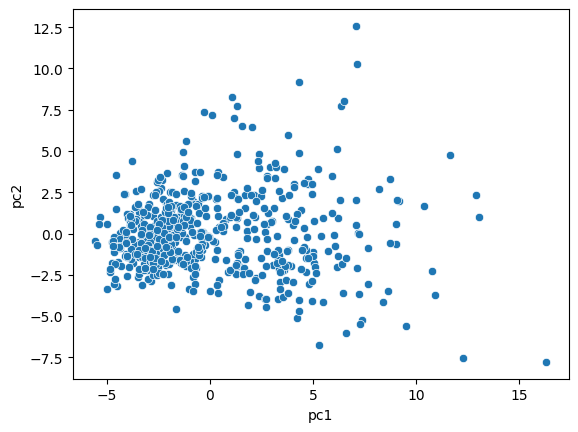

In [10]:
# 산점도로 2개의 주성분을 시각화
ax = sns.scatterplot(x='pc1', y='pc2', data=X_pca_df)

In [13]:
# Target과 확인을 위해 주성분 분석을 수행한 Input 데이터와 기존 target 데이터를 merge
# pca_df 생성: 2개의 주성분 및 1개의 target
target_df = target_df.reset_index()
pca_df = pd.merge(X_pca_df, target_df, left_index = True, right_index = True, how='inner')
pca_df = pca_df[['pc1', 'pc2', 'diagnosis']]
pca_df

,pc1,pc2,diagnosis
0,9.192837,1.948583,M
1,2.387802,-3.768172,M
2,5.733896,-1.075174,M
3,7.122953,10.275589,M
4,3.935302,-1.948072,M
...,...,...,...
564,6.439315,-3.576817,M
565,3.793382,-3.584048,M
566,1.256179,-1.902297,M
567,10.374794,1.672010,M


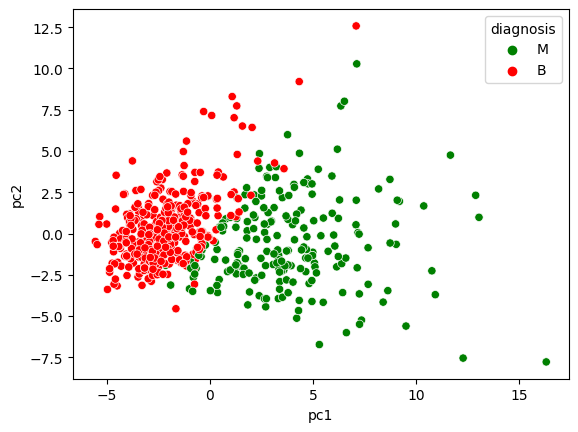

In [17]:
# 클래스 색으로 구분해 처음 두 개의 주성분으로 Target과 비교
ax = sns.scatterplot(x='pc1', y='pc2', hue='diagnosis', data=pca_df, palette=['green', 'red'])

- 실제 모델링에 효율적으로 활용 가능한 분석 방법이다.
- 특히 record, column이 많은 경우 모델링 연산 비용이 많이 들기 때문에 효율적인 차원 축소 기반의 특징을 생성하는 것이 분석 과정 내 필요
<br><br>
- 주 성분을 선택하는 다른 방안
    - 유지시킬 주성분의 개수를 지정한은 것이 아니라, 분산의 설명 가능한 수준을 비율로 선택 가능
    - pca = PCA(n_components=0.8)
    - 주성분의 수는 전체 분산의 최소 80% 수준으로 자동 선택
- 이를 통해 수치를 변경하며 추출되는 주성분의 수를 확인할 수 있으며, 이는 분산에 기초해 주성분 개수를 선택하는 과정에서 얼마나 많은 주성분을 사용할 것인지 확인해야 할 때 사용할 수 있다.

In [18]:
# 전체 분산의 최소 80% 수준의 주성분 확보
# 해당 경우 주성분이 5개가 나옴을 확인할 수 있다.
pca = PCA(n_components=0.8)
pca.fit(input_scaled)
X_pca = pca.transform(input_scaled)
X_pca_df = pd.DataFrame(X_pca)
X_pca_df

,0,1,2,3,4
0,9.192837,1.948583,-1.123166,3.633731,-1.195110
1,2.387802,-3.768172,-0.529293,1.118264,0.621775
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086
3,7.122953,10.275589,-3.232790,0.152547,-2.960878
4,3.935302,-1.948072,1.389767,2.940639,0.546747
...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723
566,1.256179,-1.902297,0.562731,-2.089227,1.809991
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742


### 2) Featurization via Clustering (군집 분석)

- 여러 개의 변수를 하나의 변수(군집 결과)로 변환 차원 축소

In [23]:
# K-means 알고리즘 활용
from sklearn.cluster import KMeans

In [21]:
# 일부 변수만 선택 (요인에 해당하는 30개 변수 중 앞의 15개 변수만 선택)
# 즉, 활용할 정보의 양을 절반으로 축소해 군집분석을 진행했을 때 어느 정도의 효율성을 보여주는지 확인
subset_df = input_df.iloc[:, 0:15]
subset_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se
id,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300
926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769
926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903


In [22]:
# K-means 알고리즘 또한 데이터 간의 거리를 토대로 군집분석을 진행하기 때문에
# 데이터 간 관측 거리가 다른 것을 맞추기 위해 데이터 스케일링
std_scaler.fit(subset_df)
subset_input_scaled = std_scaler.transform(subset_df)
subset_input_scaled

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.83303087,
         2.48757756, -0.21400165],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  0.26332697,
         0.74240195, -0.60535085],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  0.8509283 ,
         1.18133606, -0.29700501],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.27669279,
         0.1806983 , -0.37934168],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  1.43852964,
         1.0095027 , -0.17299998],
       [-1.80840125,  1.22179204, -1.81438851, ..., -0.15744905,
        -0.46615196,  0.04934236]])

In [24]:
# K-means 클러스터링 적용
k = 5
model = KMeans(n_clusters = k, random_state = 10)

In [28]:
# scaling한 데이터를 fit 하여 모델 학습
model.fit(subset_input_scaled)

# 클러스터링 결과를 Target 변수와 비교하기 위해 원 데이터에 column으로 생성
target_df['cluster'] = model.fit_predict(subset_input_scaled)

In [29]:
# 최종 데이터 확인
target_df

,level_0,index,id,diagnosis,clustering,cluster
0,0,0,842302,M,0,0
1,1,1,842517,M,2,2
2,2,2,84300903,M,2,2
3,3,3,84348301,M,4,4
4,4,4,84358402,M,2,2
...,...,...,...,...,...,...
564,564,564,926424,M,0,0
565,565,565,926682,M,2,2
566,566,566,926954,M,2,2
567,567,567,927241,M,0,0


In [30]:
# 15개의 임의의 변수로 만들어진 하나의 특징(군집 결과)과 기존 Target 변수와의 비교
pd.crosstab(target_df.diagnosis, target_df.cluster)

cluster,0,1,2,3,4
diagnosis,,,,,
B,0,111,0,229,17
M,36,5,93,26,52


- cluster (0, 2, 4)와 (1, 3)로 비교적 잘 나누어졌음을 확인할 수 있다.
- 15개보다 더 많은 데이터를 활용한다면 더 좋은 결과를 얻을 수 있겠지만
- 이처럼 많은 변수를 하나의 특징으로 구성하고 입력데이터의 차원을 줄이는 것은 모델 연산 비용 절감에 효과적일 수 있다.